In [13]:

import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy,BinaryAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature

In [14]:
train_directory="/content/drive/MyDrive/project_dataset/train"
val_directory="/content/drive/MyDrive/project_dataset/test"
class_name=["Resume_DATA","non_resume"]
CONFIGURATION ={
     "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 0.001,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 100,
    "N_DENSE_2": 10,
    "NUM_CLASSES": 1,
}

In [15]:
train_dataset=tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='binary',
    class_names=class_name,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,)

Found 970 files belonging to 2 classes.


In [16]:
val_dataset=tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='binary',
    class_names=class_name,
    color_mode='rgb',
    batch_size=16,
    image_size=(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,)

Found 212 files belonging to 2 classes.


In [17]:
for i in val_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(16, 256, 256, 3), dtype=float32, numpy=
array([[[[ 92.52827   ,  92.52827   ,  92.52827   ],
         [194.86804   , 194.86804   , 194.86804   ],
         [199.44449   , 199.44449   , 199.44449   ],
         ...,
         [119.86975   , 119.86975   , 119.86975   ],
         [ 29.352505  ,  29.352505  ,  29.352505  ],
         [ 18.304379  ,  18.304379  ,  18.304379  ]],

        [[198.75937   , 198.75937   , 198.75937   ],
         [195.36337   , 195.36337   , 195.36337   ],
         [198.0954    , 198.0954    , 198.0954    ],
         ...,
         [199.51459   , 199.51459   , 199.51459   ],
         [109.460175  , 109.460175  , 109.460175  ],
         [ 16.813835  ,  16.813835  ,  16.813835  ]],

        [[191.86174   , 191.86174   , 191.86174   ],
         [197.63303   , 197.63303   , 197.63303   ],
         [196.46721   , 196.46721   , 196.46721   ],
         ...,
         [197.21721   , 197.21721   , 197.21721   ],
         [168.23038   , 168.23038   , 168.2303

DATASET VISUALIZATION


/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


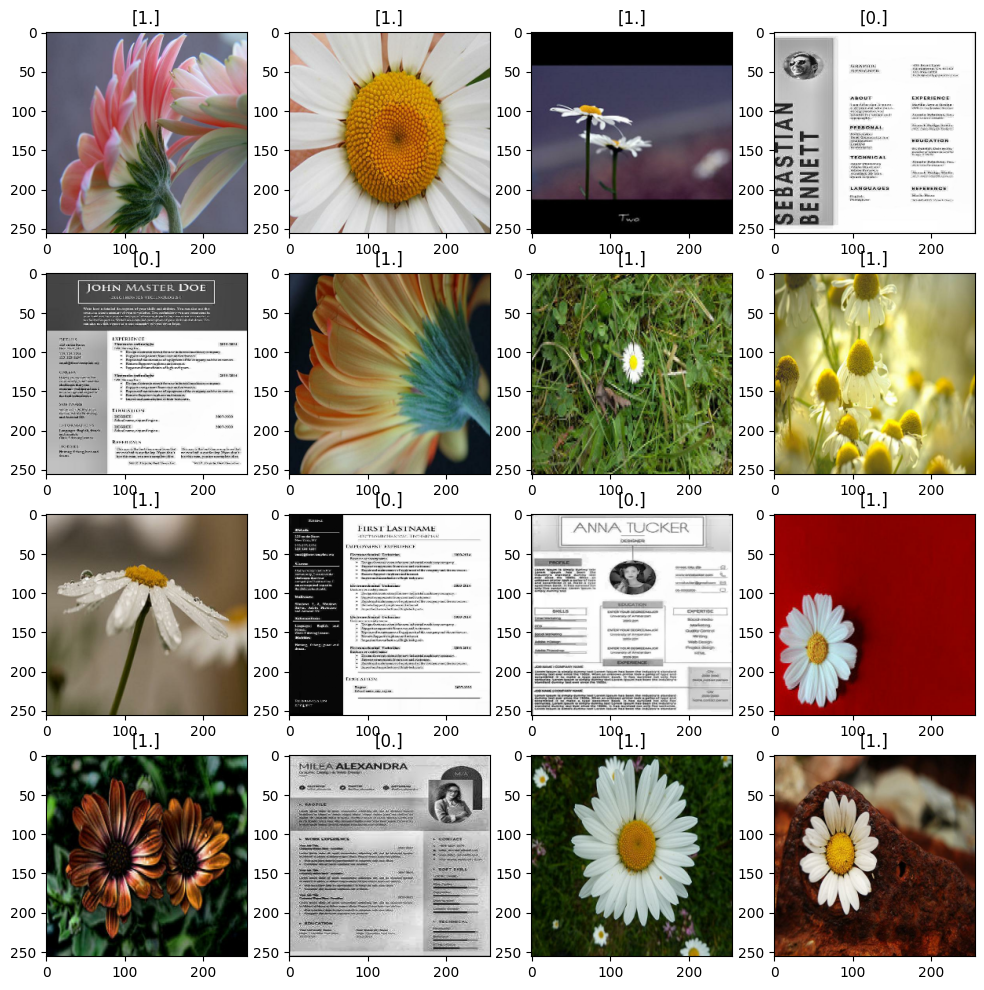

In [18]:
plt.figure(figsize=(12,12))

for images,labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(images[i]/255)
    plt.title(labels[i].numpy())

DATASET PREPARATION


In [19]:
training_dataset= (train_dataset
                   .prefetch(tf.data.AUTOTUNE))


In [20]:
validation_dataset= (val_dataset
                   .prefetch(tf.data.AUTOTUNE))

In [21]:

resize_rescale_layers = tf.keras.Sequential([
       Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
       Rescaling(1./255),
])


Modeling


In [22]:
lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3), ),

    resize_rescale_layers,

    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "sigmoid"),

])

lenet_model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 254, 254, 6)       168       
                                                                 
 batch_normalization_4 (Bat  (None, 254, 254, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 127, 127, 6)       0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 127, 127, 6)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 16)     

Traning


In [23]:
loss_function = BinaryCrossentropy()

In [24]:
metrics = [BinaryAccuracy(name='binary_accuracy')]

In [29]:
lenet_model.compile(
    optimizer =Adam(learning_rate= CONFIGURATION['LEARNING_RATE']),
    loss= loss_function,
    metrics= metrics)

In [30]:
history = lenet_model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs = CONFIGURATION['N_EPOCHS'],
    verbose=1
)

Epoch 1/20
31/31 [==============================] - 109s 3s/step - loss: 0.1632 - binary_accuracy: 0.9608 - val_loss: 0.2402 - val_binary_accuracy: 0.9481
Epoch 2/20
31/31 [==============================] - 6s 180ms/step - loss: 0.0779 - binary_accuracy: 0.9907 - val_loss: 0.6395 - val_binary_accuracy: 0.4670
Epoch 3/20
31/31 [==============================] - 5s 123ms/step - loss: 0.0429 - binary_accuracy: 0.9948 - val_loss: 1.5355 - val_binary_accuracy: 0.3632
Epoch 4/20
31/31 [==============================] - 7s 172ms/step - loss: 0.0302 - binary_accuracy: 0.9969 - val_loss: 2.0860 - val_binary_accuracy: 0.3632
Epoch 5/20
31/31 [==============================] - 5s 130ms/step - loss: 0.0171 - binary_accuracy: 1.0000 - val_loss: 2.4230 - val_binary_accuracy: 0.3632
Epoch 6/20
31/31 [==============================] - 6s 166ms/step - loss: 0.0176 - binary_accuracy: 0.9979 - val_loss: 2.4233 - val_binary_accuracy: 0.3632
Epoch 7/20
31/31 [==============================] - 5s 129ms/step

Evaluation


In [31]:
lenet_model.evaluate(validation_dataset)

14/14 [==============================] - 2s 58ms/step - loss: 0.0014 - binary_accuracy: 1.0000


[0.0013845165958628058, 1.0]

CONFUSION MATRIX

In [33]:
predicted=[]
labels=[]

for im ,label in validation_dataset:
  predicted.append(lenet_model(im))
  labels.append(label.numpy())

In [41]:
label

[array([[0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.]], dtype=float32),
 array([[0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.]], dtype=float32),
 array([[0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.]], dtype=float32),
 array([[1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], dtype=float32),
 array([[0.],
        [0.],
        

In [43]:
flattened_labels = [label for sublist in labels for label in sublist]
labels_array = np.array(flattened_labels)
labels_array = labels_array.astype(int)

In [45]:
predicted_probs = [tensor.numpy().flatten() for tensor in predicted]
predicted_probs_np = np.concatenate(predicted_probs)

[[135   0]
 [  0  77]]


Text(0.5, 58.7222222222222, 'Predicted')

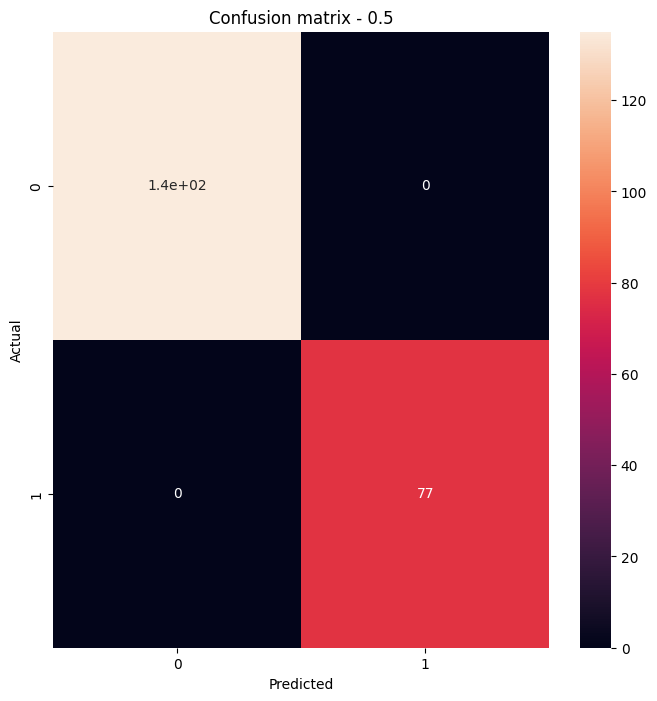

In [46]:
threshold = 0.5

cm = confusion_matrix(labels_array, predicted_probs_np> threshold)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix - {}'.format(threshold))
plt.ylabel('Actual')
plt.xlabel('Predicted')